In [1]:
import json
from typing import Iterable, Tuple, Callable, List
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons, make_gaussian_quantiles

# Linear Regression

In [2]:
def generate_sample(
        x_min: float, 
        x_max: float, 
        sample_size: int, 
        f: Callable[[np.ndarray], np.ndarray]
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    step = (x_max - x_min) / (sample_size - 1)

    x = np.arange(start=x_min, stop=x_max + step, step=step)

    eps = np.random.normal(loc=0.0, scale=0.25, size=x.size)

    y = f(x) + eps

    x_real = np.arange(start=x_min, stop=x_max, step=step/10)

    y_real = f(x_real)

    plt.plot(x_real, y_real, color='k', label='ground truth')
    plt.plot(x, y, 'o', label='sample')
    plt.legend()
    plt.show()
    
    return x, y, x_real, y_real

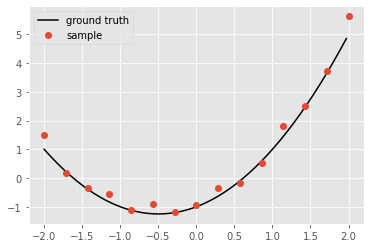

In [3]:
x, y, x_real, y_real = generate_sample(x_min=-2, x_max=2, sample_size=15, f=lambda x: x ** 2 + x - 1)

In [4]:
class PolynomialFeaturizer1D(BaseEstimator, TransformerMixin):
    
    def __init__(self, order: int=0) -> None:
        self.order = order
        
    def fit(self, x: np.ndarray, y: np.ndarray=None) -> 'PolynomialFeaturizer1D':
        return self
        
    def transform(self, x: np.ndarray) -> np.ndarray:
        return np.hstack([
            x.reshape(-1, 1) ** i 
            for i in range(0, self.order + 1, 1)
        ])

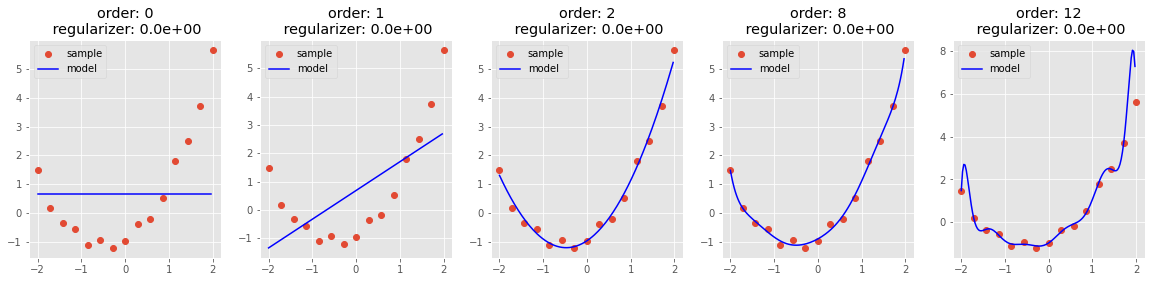

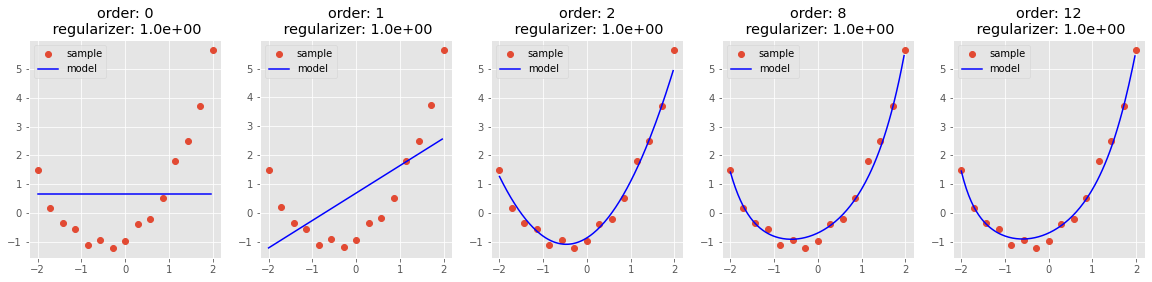

In [5]:
orders = [0, 1, 2, 8, 12]
alphas = [0, 1]

for alpha in alphas:
    plt.figure(figsize=(4 * len(orders), 4))
    for i, order in enumerate(orders):

        y_pred = (
            Pipeline([
                ('features', PolynomialFeaturizer1D(order=order)),
                ('scaler', StandardScaler()),
                ('model', LinearRegression() if alpha == 0 else Ridge(alpha=alpha))
            ])
            .fit(x, y)
            .predict(x_real.reshape(-1, 1))
        )

        plt.subplot(1,len(orders),i+1)
        plt.title(f'order: {order}\n regularizer: {alpha:.1e}')
        plt.plot(x, y, 'o', label='sample')
        plt.plot(x_real, y_pred, color='b', label='model')
        plt.legend()
    plt.show()

# K Nearest Neighbors

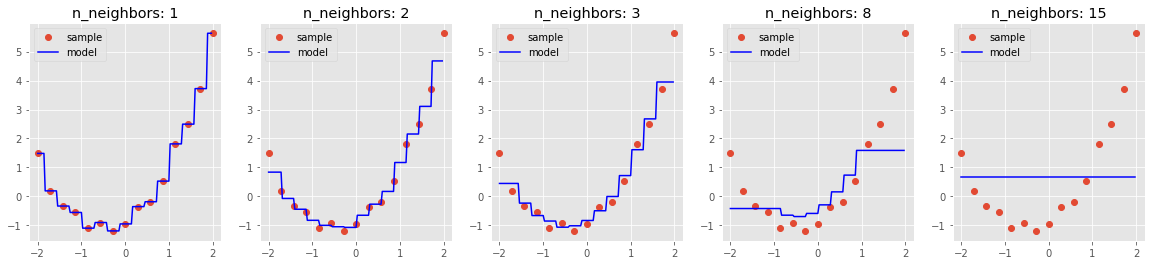

In [6]:
n_neighbors = [1, 2, 3, 8, 15]

plt.figure(figsize=(4 * len(orders), 4))
for i, n in enumerate(n_neighbors):
    
    y_pred = (
        KNeighborsRegressor(n_neighbors=n)
        .fit(x.reshape(-1, 1), y)
        .predict(x_real.reshape(-1, 1))
    )
    
    plt.subplot(1,len(orders),i+1)
    plt.title(f'n_neighbors: {n}')
    plt.plot(x, y, 'o', label='sample')
    plt.plot(x_real, y_pred, color='b', label='model')
    plt.legend()
plt.show()

# Bias - Variance decomposition

$\vec{x} \in \mathbb{R}^d$ — признаки объекта (features, factors)\
$y$ — целевая переменная (target)\
признаки объектов и их целевые переменные сэмплируются из неизвестного нам распределения $p\left(\vec{x}, y\right) = p\left(\vec{x}\right)p\left(y | \vec{x}\right)$\
обучающая выборка: $D = \{\left(\vec{x}_n, y_n\right) \}_{n=1}^N$\
хотим построить алгорим $f(\vec{x}) : f(\vec{x}) \sim y$\
как выбрать лучший алгоритм? для ответа на этот вопрос нужен критерий качества: $\mathcal{L}(y, f(\vec{x})) = (y - f(\vec{x}))^2$\
И оценивать качество нужно не в одной точке, а по всему распределению => приходим к **EPE**:

$EPE$ — Expected Prediction Error:


$$
EPE\left[f\right] = \mathbb{E}_{p(\vec{x},y)} [\mathcal{L}\left(f(\vec{x}), y\right)] = \int (y - f(\vec{x}))^2 p\left(\vec{x},y\right)d\vec{x}dy
$$

$$
EPE\left[f\right] = \int \left[ \int \left(y - f(\vec{x})\right)^2 p\left(y|\vec{x}\right)dy \right] p\left(\vec{x}\right)d\vec{x}
$$
<br>
<br>
<center> поточечная минимизация внутреннего интеграла: </center>

$$
\int \left(y - f(\vec{x})\right)^2 p\left(y|\vec{x}\right)dy \to \text{min}
$$

$$
\int \left(y - a\right)^2 p\left(y\right)dy \to \text{min}
$$

$$
\frac{d}{da} \left( \int \left(y - a\right)^2 p\left(y\right)dy \right) = 0 \implies -2\int \left(y - a\right) p\left(y\right)dy = 0 \implies a^{*} = \int y p(y) dy = \mathbb{E}_p[y]
$$

$$\hat{f}\left(\vec{x}\right) = \mathbb{E}_{p\left(y|\vec{x}\right)}[y] = \int y p\left(y|\vec{x}\right)dy$$

<br>
<br>
<center> чем ограничен снизу минимизируемый интеграл? </center>

$$
\int \left(y - a\right)^2 p\left(y\right)dy = \int \left(y - \mathbb{E}y + \mathbb{E}y  - a\right)^2 p\left(y\right)dy = \int \left(y - \mathbb{E}y \right)^2 p\left(y\right)dy + \int \left(\mathbb{E}y  - a \right)^2 p\left(y\right)dy + 2 \int \left(y - \mathbb{E}y \right) \left(\mathbb{E}y  - a \right) p\left(y\right)dy
$$

$$
= \sigma_y + \int \left(\mathbb{E}y  - a \right)^2 p\left(y\right)dy + 0 = \sigma_y + \int \left(\mathbb{E}y  - a \right)^2 p\left(y\right)dy
$$

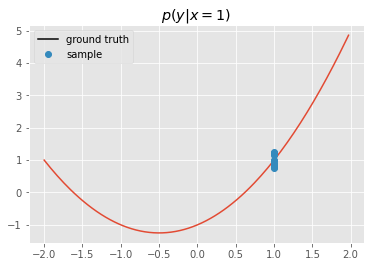

0.9974969500986522


In [7]:
plt.plot(x_real, y_real)
plt.title('$p(y | x = 1)$')
_, y_sample, _, _ = generate_sample(x_min=1-1e-5, x_max=1+1e-5, sample_size=10, f=lambda x: x ** 2 + x - 1)
print(y_sample.mean())

что происходит в kNN:
$$\hat{f}\left(\vec{x}\right) = \mathbb{E}_{p\left(y|\vec{x}\right)}[y] \approx \frac{1}{k} \displaystyle \sum_{ y_i \sim p\left(y_i|\vec{x}\right) }^k y_i \approx \frac{1}{k}  \displaystyle \sum_{ y_i \in \text{kNN}\left(\vec{x}\right) }^k y_i $$

$\hat{f}\left(\vec{x}\right) = \mathbb{E}_{p\left(y|\vec{x}\right)}[y] = \int y p\left(y|\vec{x}\right)dy$ — идеальный ответ, к которому мы не приходим\
в результате обучения на датасете $D$ мы получаем алгоритм $f\left(\vec{x}\right)$. Оценка ошибки:

$$
EPE\left[f\right] =  \int \left(y - f\left(\vec{x}\right)\right)^2 p\left(\vec{x}, y\right)d\vec{x}dy = \int \left(y - \hat{f}\left(\vec{x}\right) + \hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right)^2 p\left(\vec{x}, y\right)d\vec{x}dy =
$$
$$
 = \int \left(y - \hat{f}\left(\vec{x}\right)\right)^2 p\left(\vec{x},y\right)d\vec{x}dy +  \int \left(\hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right)^2 p\left(\vec{x}, y\right)d\vec{x}dy + 2 \int \left(y - \hat{f}\left(\vec{x}\right)\right) \left(\hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right) p\left(\vec{x}, y\right)d\vec{x}dy =
$$

$$
 = \mathbb{E} \left[ \left(y - \hat{f}\left(\vec{x}\right)\right)^2 \right] + \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right)^2 \right]
$$

* $\mathbb{E} \left[ \left(y - \hat{f}\left(\vec{x}\right)\right)^2 \right]$ — irreducible error (noise), ошибка, на которую мы никак не можем повлиять
* $\mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right)^2 \right]$ — близость построенного алгоритма к идеальному ответу

$D \sim p\left(\vec{x}, y\right), f = f\left(\vec{x} | \theta\right) = f\left(\vec{x}, D\right)$

параметры алгоритма зависят от обучающей выборки => поскольку выборка случайна, случаен и $f\left(\vec{x}\right)$, можно оценить его мат. ожидание: $\mathbb{E}_Df$

$$\mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) - f\left(\vec{x}\right)\right)^2 \right] = \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df + \mathbb{E}_Df - f\left(\vec{x}\right)\right)^2 \right] = $$
$$ = \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df\right)^2 \right] + \mathbb{E} \left[ \left(\mathbb{E}_Df - f\left(\vec{x}\right)\right)^2 \right] + 2\mathbb{E} \left[\left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df\right)\left(\mathbb{E}_Df - f\left(\vec{x}\right)\right) \right] = $$
$$ = \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df\right)^2 \right] + \mathbb{E} \left[ \left(\mathbb{E}_Df - f\left(\vec{x}\right)\right)^2 \right]$$

Итак, bias-variance decomposition:
$$
EPE\left[f\right] = \mathbb{E} \left[ \left(y - \hat{f}\left(\vec{x}\right)\right)^2 \right] + \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df\right)^2 \right] + \mathbb{E} \left[ \left(\mathbb{E}_Df - f\left(\vec{x}\right)\right)^2 \right] = \sigma^2 + \text{bias}^2 + \text{variance}
$$

* $ \sigma^2  = \mathbb{E} \left[ \left(y - \hat{f}\left(\vec{x}\right)\right)^2 \right] $ — неконтролируемый шум в данных
* $ \text{bias}^2 = \mathbb{E} \left[ \left(\hat{f}\left(\vec{x}\right) -\mathbb{E}_Df\right)^2 \right] $ — смещение модели: если сэмплировать выборки из генеральной совокупности, обучить на каждой модель и усреднить предсказания, как далеки усредненные предсказания от идеального ответа?
* $ \text{variance} = \mathbb{E} \left[ \left(\mathbb{E}_Df - f\left(\vec{x}\right)\right)^2 \right] $ — дисперсия модели: как сильно меняется модель при варьировании обучающей выборки из той же генеральной совокупности?

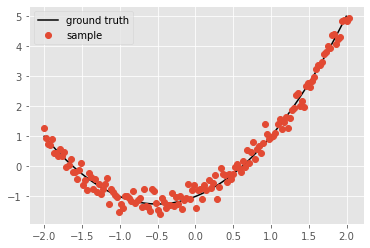

In [8]:
x, y, x_real, y_real = generate_sample(x_min=-2, x_max=2, sample_size=150, f=lambda x: x ** 2 + x - 1)

## Variance

In [9]:
def plot_individual_models_predictions(
        x: np.ndarray,
        y: np.ndarray,
        orders: Iterable[int],
        alphas: Iterable[float],
        sample_size: int,
        n_trials: int,
        y_lims = Tuple[float]
    ) -> None:
    
    for alpha in alphas:
        plt.figure(figsize=(4 * len(orders), 4))
        for i, order in enumerate(orders):

            plt.subplot(1,len(orders),i+1)
            plt.title(f'order: {order}\n alpha: {alpha:.1e}')
            plt.plot(x, y, 'o', label='sample')

            for _ in range(n_trials):
                rand_ids = np.random.randint(low=0, high=x.size-1, size=sample_size)

                x_sample, y_sample = x[rand_ids], y[rand_ids] 

                y_pred = (
                    Pipeline([
                        ('features', PolynomialFeaturizer1D(order=order)),
                        ('scaler', StandardScaler()),
                        ('model', LinearRegression() if alpha == 0 else Ridge(alpha=alpha))
                    ])
                    .fit(x_sample, y_sample)
                    .predict(x.reshape(-1, 1))
                )
                plt.plot(x, y_pred, color='b', alpha=5/n_trials)
            plt.legend()
            plt.ylim(y_lims)
        plt.show()

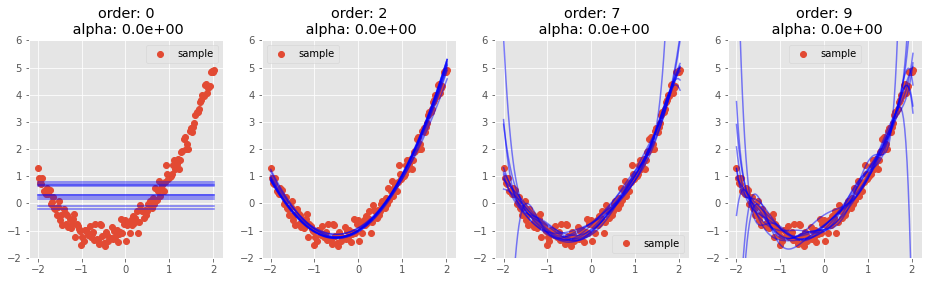

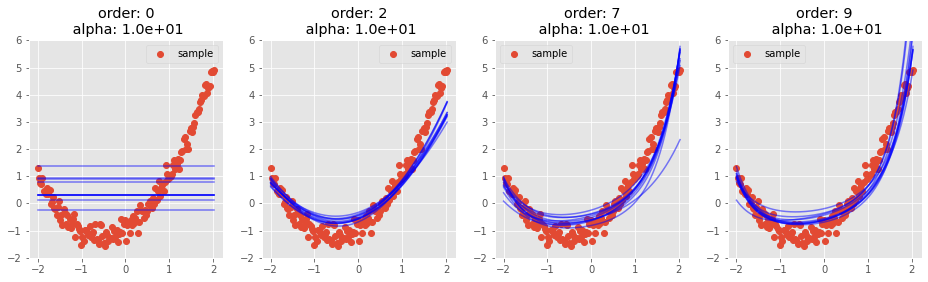

In [10]:
plot_individual_models_predictions(
    x, y, orders=[0, 2, 7, 9], alphas=[0, 10], sample_size=20, n_trials=10, y_lims=(-2, 6)
)

## bias

In [11]:
def plot_averaged_models_predictions(
        x: np.ndarray,
        y: np.ndarray,
        orders: Iterable[int],
        alphas: Iterable[float],
        sample_size: int,
        n_trials: int,
        y_lims = Tuple[float]
    ) -> None:
    
    for alpha in alphas:
        plt.figure(figsize=(4 * len(orders), 4))
        for i, order in enumerate(orders):

            plt.subplot(1,len(orders),i+1)
            plt.title(f'order: {order}\n alpha: {alpha:.1e}')
            plt.plot(x, y, 'o', label='sample')
            
            y_pred = np.zeros_like(y)

            for _ in range(n_trials):
                rand_ids = np.random.randint(low=0, high=x.size-1, size=sample_size)

                x_sample, y_sample = x[rand_ids], y[rand_ids] 

                y_pred += (
                    Pipeline([
                        ('features', PolynomialFeaturizer1D(order=order)),
                        ('scaler', StandardScaler()),
                        ('model', LinearRegression() if alpha == 0 else Ridge(alpha=alpha))
                    ])
                    .fit(x_sample, y_sample)
                    .predict(x.reshape(-1, 1))
                )
            
            y_pred /= n_trials
            plt.plot(x, y_pred, color='b', label='model')
            plt.legend()
            plt.ylim(y_lims)
        plt.show()

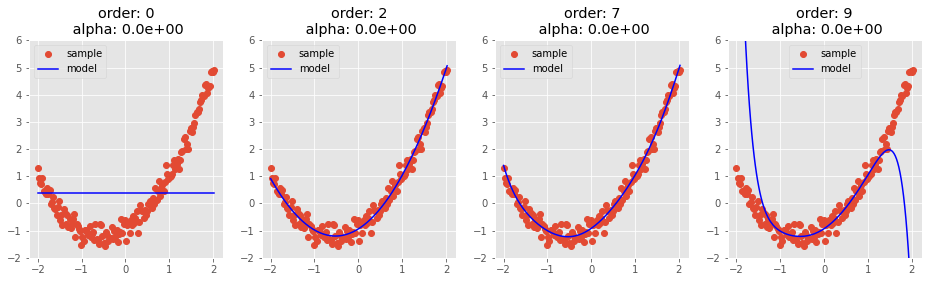

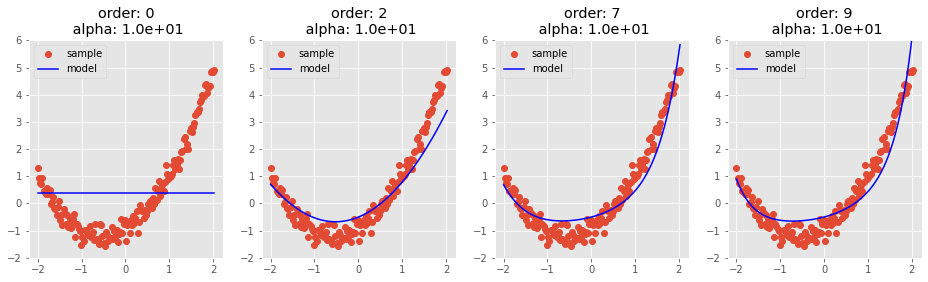

In [12]:
plot_averaged_models_predictions(
    x, y, orders=[0, 2, 7, 9], alphas=[0, 10], sample_size=20, n_trials=1_000, y_lims=(-2, 6)
)

# Classification

In [13]:
def plot_classifier_proba(x, y, sample_size, classifier, params_list: List[dict], n_trials, grid_step=0.1) -> None:
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step)
    )
    
    Z = defaultdict(lambda: np.zeros_like(xx))
    
    for _ in range(n_trials):
        
        rand_ids = np.random.randint(low=0, high=x.shape[0]-1, size=sample_size)
        x_sample, y_sample = x[rand_ids], y[rand_ids]
        
        for i, params in enumerate(params_list):
            
            key = json.dumps(params, sort_keys=True)
            
            Z[key] += (
                classifier(**params)
                .fit(x_sample, y_sample)
                .predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                .reshape(xx.shape)  
            )
    
    plt.figure(figsize=(5 * len(params_list), 4))
    for i, params in enumerate(params_list):
        key = json.dumps(params, sort_keys=True)
        plt.subplot(1,len(params_list),i+1)
        plt.pcolormesh(xx, yy, Z[key] / n_trials, shading='auto', cmap='plasma')
        plt.colorbar()
        plt.title("\n".join([f'{k}: {v}' for k, v in params.items()]) + f'\n n_trials: {n_trials}')
        plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap='plasma', alpha=0.5)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

    plt.show()

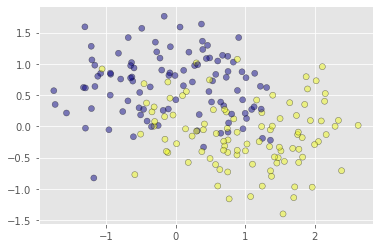

In [14]:
x, y = make_moons(noise=0.4, n_samples=200, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap='plasma', alpha=0.5);

### kNN Classifier

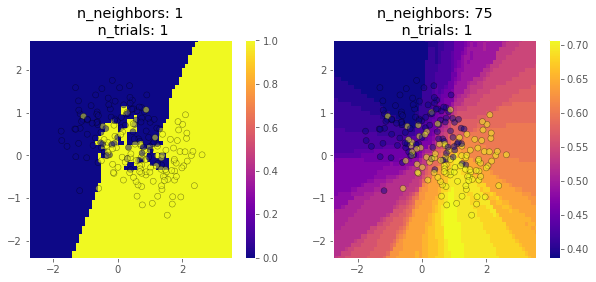

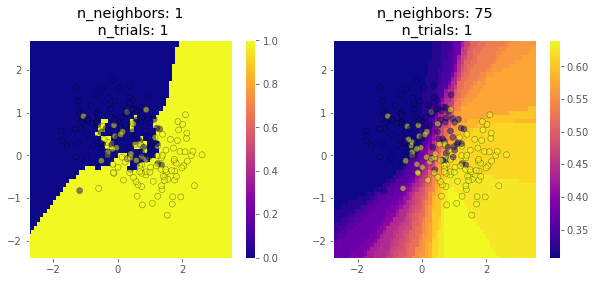

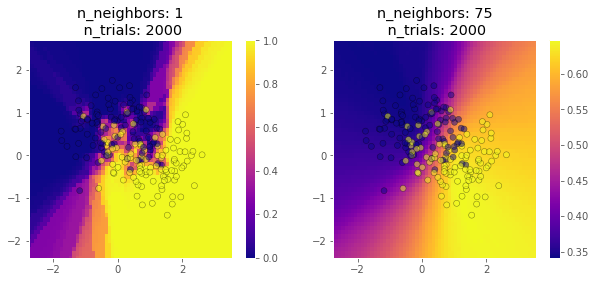

In [15]:
for n_trials in (1, 1, 2000):

    plot_classifier_proba(
        x, y, sample_size=100, classifier=KNeighborsClassifier,
        params_list=[{"n_neighbors": n} for n in (1, 75)],
        n_trials=n_trials
    )

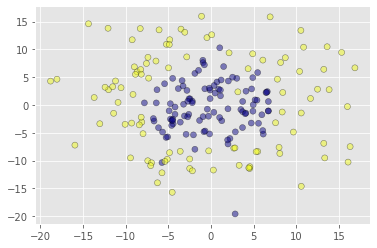

In [16]:
x, y = make_gaussian_quantiles(n_samples=200, cov=50, n_classes=2, random_state=0)

rand_ids = np.random.randint(low=0, high=y.size, size=5)

y[rand_ids] = np.array([int(not y_) for y_ in y[rand_ids]])

plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap='plasma', alpha=0.5);

### Desicion Tree Classifier

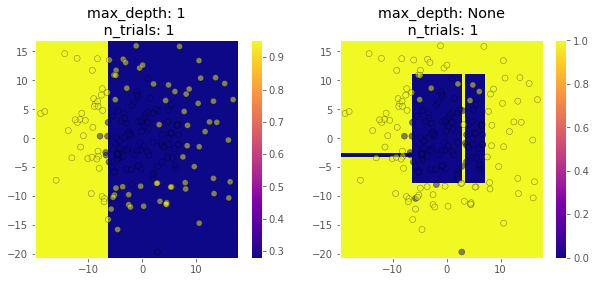

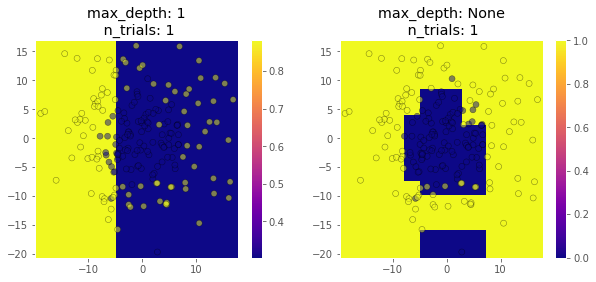

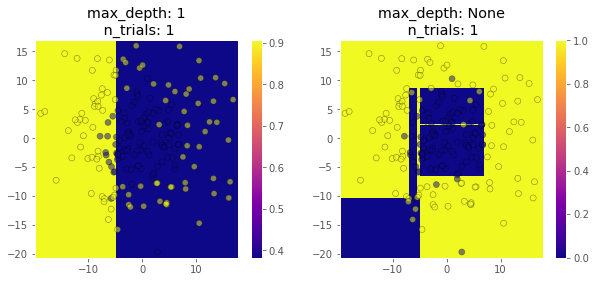

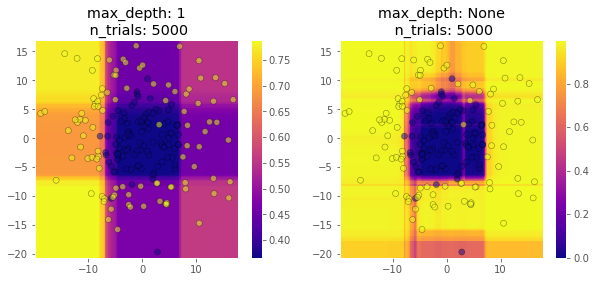

In [17]:
for n_trials in (1, 1, 1, 5_000):
    plot_classifier_proba(
        x, y, sample_size=100, classifier=DecisionTreeClassifier,
        params_list=[{"max_depth": n} for n in (1, None)],
        n_trials=n_trials
    )

### Logistic Regression

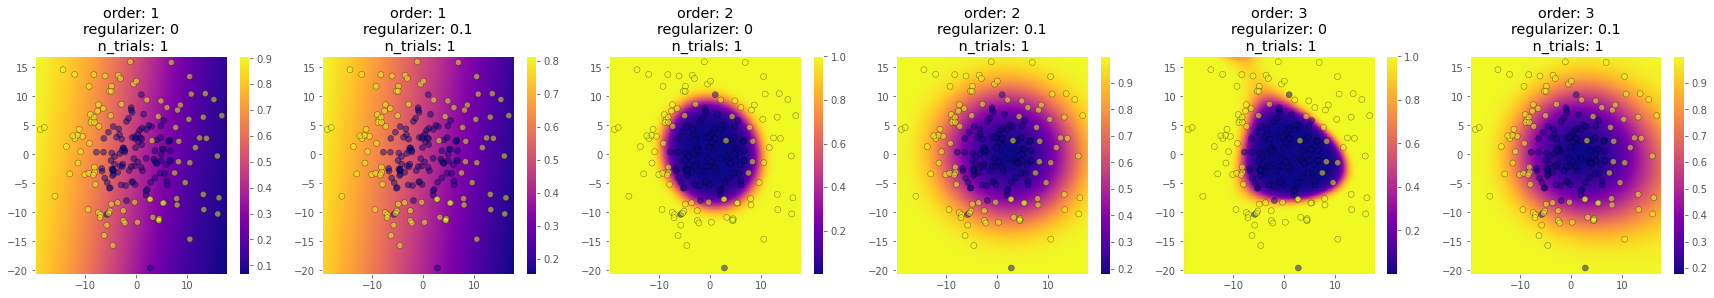

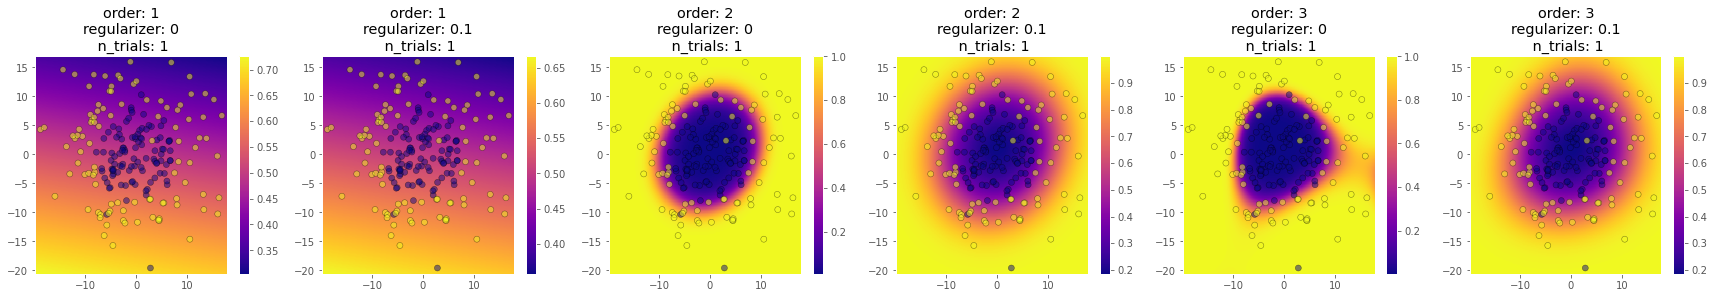

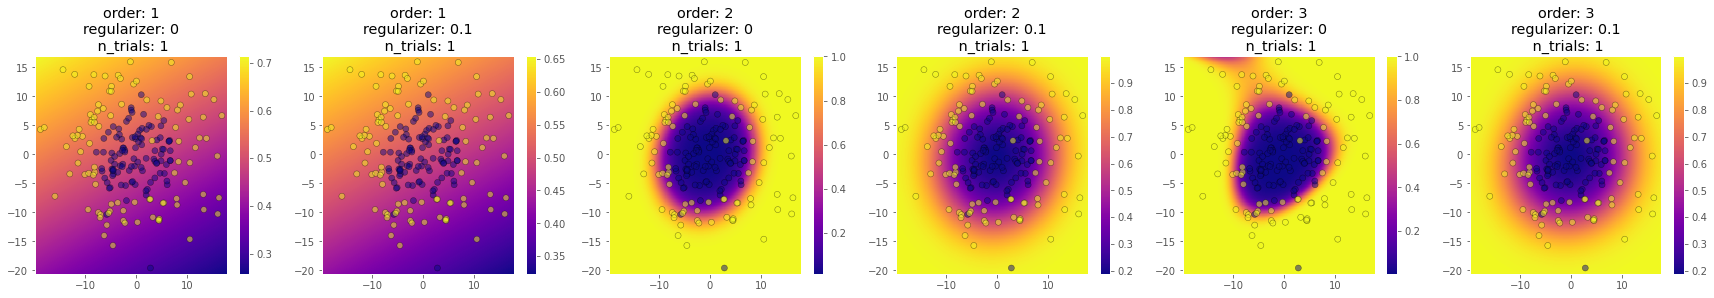

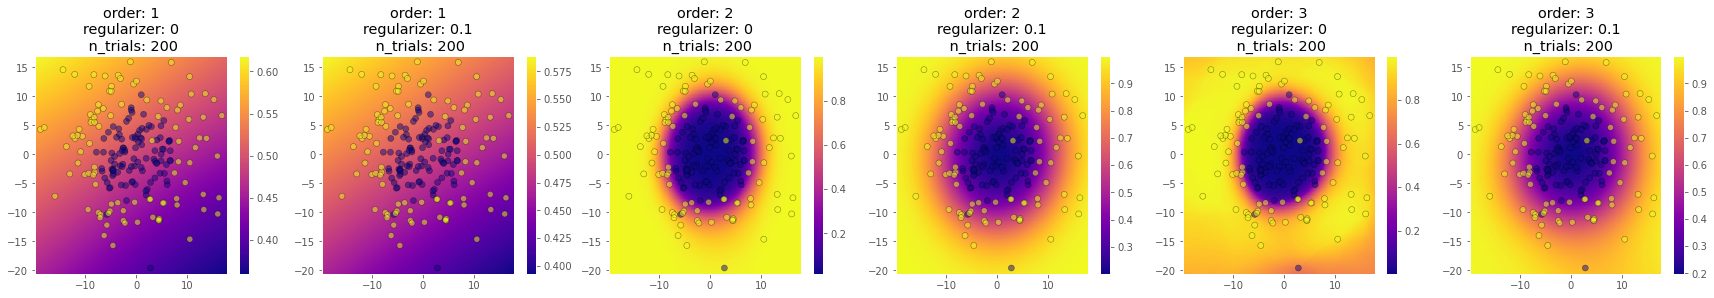

In [18]:
class PolynomialFeaturizer2D(BaseEstimator, TransformerMixin):
    
    def __init__(self, order: int=0) -> None:
        self.order = order
        
    def fit(self, x: np.ndarray, y: np.ndarray=None) -> 'PolynomialFeaturizer2D':
        return self
        
    def transform(self, x: np.ndarray) -> np.ndarray:
        return np.hstack([
            x[:,[0]] ** (n - k) * x[:, [1]] ** k
            for n in range(self.order + 1)
            for k in range(n + 1)
        ])

def get_polynomial_log_reg(order, regularizer=0):
    
    clf_params = {
        'fit_intercept': False,
        'penalty': 'none',
        'max_iter': 10_000
    }
    if regularizer > 0:
        clf_params['penalty'] = 'l2'
        clf_params['C'] = regularizer
    
    return Pipeline([
        ('features', PolynomialFeaturizer2D(order=order)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(**clf_params))
    ])


for n_trials in (1, 1, 1, 200):
    plot_classifier_proba(
        x, y, sample_size=100, classifier=get_polynomial_log_reg,
        params_list=[{"order": n, "regularizer": c} for n in (1, 2, 3) for c in (0, 0.1)],
        n_trials=n_trials
    )